In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.losses import BinaryCrossentropy
from datetime import datetime 
import cv2
from PIL import Image

C:\Users\farha\Anaconda3\envs\kaggle\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\farha\Anaconda3\envs\kaggle\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\farha\Anaconda3\envs\kaggle\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
image_directory = 'patches/images/'
mask_directory = 'patches/masks/'


SIZE = 256
image_dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.  
mask_dataset = []  #Place holders to define add labels. We will add 0 to all parasitized images and 1 to uninfected.

images = os.listdir(image_directory)
for i, image_name in enumerate(images):    #Remember enumerate method adds a counter and returns the enumerate object
    if (image_name.split('.')[1] == 'tif'):
        #print(image_directory+image_name)
        image = cv2.imread(image_directory+image_name, 1)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        image_dataset.append(np.array(image))



#Normalize images
image_dataset = np.array(image_dataset)/255.

In [3]:

#Iterate through all images in Uninfected folder, resize to 64 x 64
#Then save into the same numpy array 'dataset' but with label 1

masks = os.listdir(mask_directory)
for i, image_name in enumerate(masks):
    if (image_name.split('.')[1] == 'tif'):
        image = cv2.imread(mask_directory+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        mask_dataset.append(np.array(image))


#D not normalize masks, just rescale to 0 to 1.
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.

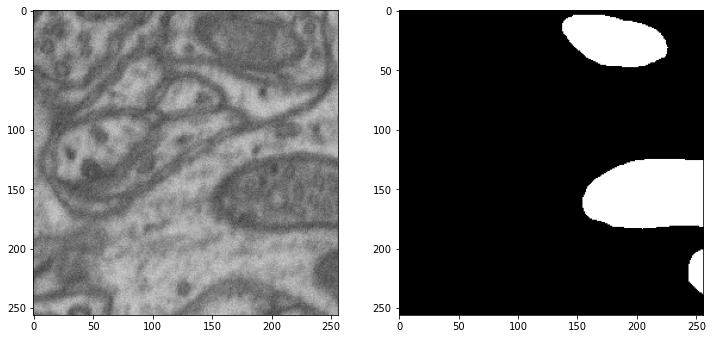

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.30, random_state = 0)

#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (256, 256, 3)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (256, 256)), cmap='gray')
plt.show()

#######################################
#Parameters for model

IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

num_labels = 1  #Binary
input_shape = (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)
batch_size = 8


In [5]:
X_train.shape

(344, 256, 256, 3)

In [6]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [7]:
from focal_loss import binary_focal_loss
#FOCAL LOSS AND DICE METRIC
#Focal loss helps focus more on tough to segment classes.
# from focal_loss import BinaryFocalLoss

###############################################################################


#Try various models: Unet, Attention_UNet, and Attention_ResUnet
#Rename original python file from 224_225_226_models.py to models.py
from models import Attention_ResUNet, UNet, Attention_UNet, dice_coef, dice_coef_loss, jacard_coef

Model: "UNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           batch_normalization[0][0]        
_______________________________________________________________________________________________

In [8]:


'''
UNet
'''
unet_model = UNet(input_shape)
unet_model.compile(optimizer=Adam(lr = 1e-2), loss=binary_focal_loss(gamma=2), 
              metrics=['accuracy', jacard_coef])


Model: "UNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 256, 256, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 256, 256, 64) 256         conv2d_19[0][0]                  
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 256, 256, 64) 0           batch_normalization_19[0][0]     
_______________________________________________________________________________________________

In [9]:


print(unet_model.summary())

start1 = datetime.now() 
unet_history = unet_model.fit(X_train, y_train, 
                    verbose=1,
                    batch_size = 2,
                    validation_data=(X_test, y_test ), 
                    shuffle=False,
                    epochs=30)

stop1 = datetime.now()
#Execution time of the model 
execution_time_Unet = stop1-start1
print("UNet execution time is: ", execution_time_Unet)

unet_model.save('mitochondria_UNet_50epochs_B_focal.hdf5')

Model: "UNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 256, 256, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 256, 256, 64) 256         conv2d_19[0][0]                  
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 256, 256, 64) 0           batch_normalization_19[0][0]     
_______________________________________________________________________________________________

Epoch 1/30
172/172 [==============================] - 83s 485ms/step - loss: 14.7580 - accuracy: 0.8821 - jacard_coef: 0.0896 - val_loss: 7.8815 - val_accuracy: 0.9262 - val_jacard_coef: 0.0532
Epoch 2/30
172/172 [==============================] - 82s 476ms/step - loss: 4.4432 - accuracy: 0.9411 - jacard_coef: 0.1359 - val_loss: 4.8138 - val_accuracy: 0.9314 - val_jacard_coef: 0.0830
Epoch 3/30
172/172 [==============================] - 82s 476ms/step - loss: 3.4130 - accuracy: 0.9438 - jacard_coef: 0.1592 - val_loss: 2.7103 - val_accuracy: 0.9455 - val_jacard_coef: 0.1335
Epoch 4/30
172/172 [==============================] - 82s 477ms/step - loss: 3.1075 - accuracy: 0.9440 - jacard_coef: 0.1740 - val_loss: 3.4376 - val_accuracy: 0.9379 - val_jacard_coef: 0.1335
Epoch 5/30
172/172 [==============================] - 82s 477ms/step - loss: 2.6607 - accuracy: 0.9518 - jacard_coef: 0.2007 - val_loss: 2.6579 - val_accuracy: 0.9492 - val_jacard_coef: 0.1473
Epoch 6/30
172/172 [==============

In [10]:

#____________________________________________
'''
Attention UNet1
'''
att_unet_model = Attention_UNet(input_shape)

att_unet_model.compile(optimizer=Adam(lr = 1e-2), loss=binary_focal_loss(gamma=2), 
              metrics=['accuracy', jacard_coef])

In [11]:

print(att_unet_model.summary())
start2 = datetime.now() 
att_unet_history = att_unet_model.fit(X_train, y_train, 
                    verbose=1,
                    batch_size = 2,
                    validation_data=(X_test, y_test ), 
                    shuffle=False,
                    epochs=15)
stop2 = datetime.now()
#Execution time of the model 
execution_time_Att_Unet = stop2-start2
print("Attention UNet execution time is: ", execution_time_Att_Unet)

att_unet_model.save('mitochondria_Attention_UNet_50epochs_B_focal.hdf5')
    

Model: "Attention_UNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 256, 256, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_38 (BatchNo (None, 256, 256, 64) 256         conv2d_38[0][0]                  
__________________________________________________________________________________________________
activation_38 (Activation)      (None, 256, 256, 64) 0           batch_normalization_38[0][0]     
_____________________________________________________________________________________

Epoch 1/30
172/172 [==============================] - 102s 591ms/step - loss: 15.3306 - accuracy: 0.8345 - jacard_coef: 0.0926 - val_loss: 15.8597 - val_accuracy: 0.8213 - val_jacard_coef: 0.1111
Epoch 2/30
172/172 [==============================] - 101s 585ms/step - loss: 4.5294 - accuracy: 0.9442 - jacard_coef: 0.1381 - val_loss: 6.5155 - val_accuracy: 0.9448 - val_jacard_coef: 0.1335
Epoch 3/30
172/172 [==============================] - 101s 585ms/step - loss: 3.4919 - accuracy: 0.9436 - jacard_coef: 0.1566 - val_loss: 2.2291 - val_accuracy: 0.9625 - val_jacard_coef: 0.1591
Epoch 4/30
172/172 [==============================] - 101s 586ms/step - loss: 3.5427 - accuracy: 0.9371 - jacard_coef: 0.1602 - val_loss: 518.1967 - val_accuracy: 0.1747 - val_jacard_coef: 0.0743
Epoch 5/30
172/172 [==============================] - 101s 585ms/step - loss: 3.3785 - accuracy: 0.9362 - jacard_coef: 0.1650 - val_loss: 5.2752 - val_accuracy: 0.9262 - val_jacard_coef: 0.0739
Epoch 6/30
172/172 [======

In [12]:

#___________________________________________
'''
Attention Residual Unet
'''
att_res_unet_model = Attention_ResUNet(input_shape)

att_res_unet_model.compile(optimizer=Adam(lr = 1e-2), loss=binary_focal_loss(gamma=2), 
              metrics=['accuracy', jacard_coef])



In [13]:

# att_res_unet_model.compile(optimizer=Adam(lr = 1e-3), loss='binary_crossentropy', 
#               metrics=['accuracy', jacard_coef])

print(att_res_unet_model.summary())


start3 = datetime.now() 
att_res_unet_history = att_res_unet_model.fit(X_train, y_train, 
                    verbose=1,
                    batch_size = 2,
                    validation_data=(X_test, y_test ), 
                    shuffle=False,
                    epochs=15)
stop3 = datetime.now()

#Execution time of the model 
execution_time_AttResUnet = stop3-start3
print("Attention ResUnet execution time is: ", execution_time_AttResUnet)

att_res_unet_model.save('mitochondria_AttResUnet_50epochs_B_focal.hdf5')


Model: "AttentionResUNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_77 (Conv2D)              (None, 256, 256, 64) 1792        input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_65 (BatchNo (None, 256, 256, 64) 256         conv2d_77[0][0]                  
__________________________________________________________________________________________________
activation_69 (Activation)      (None, 256, 256, 64) 0           batch_normalization_65[0][0]     
___________________________________________________________________________________

Epoch 1/30
172/172 [==============================] - 117s 683ms/step - loss: 13.3236 - accuracy: 0.8944 - jacard_coef: 0.1115 - val_loss: 6.7158 - val_accuracy: 0.9247 - val_jacard_coef: 0.0601
Epoch 2/30
172/172 [==============================] - 116s 677ms/step - loss: 4.2227 - accuracy: 0.9474 - jacard_coef: 0.1486 - val_loss: 6.6896 - val_accuracy: 0.9473 - val_jacard_coef: 0.1582
Epoch 3/30
172/172 [==============================] - 117s 678ms/step - loss: 3.1429 - accuracy: 0.9498 - jacard_coef: 0.1710 - val_loss: 2.9099 - val_accuracy: 0.9508 - val_jacard_coef: 0.1544
Epoch 4/30
172/172 [==============================] - 116s 677ms/step - loss: 2.6962 - accuracy: 0.9542 - jacard_coef: 0.1947 - val_loss: 1.8726 - val_accuracy: 0.9803 - val_jacard_coef: 0.2289
Epoch 5/30
172/172 [==============================] - 116s 677ms/step - loss: 2.3949 - accuracy: 0.9585 - jacard_coef: 0.2170 - val_loss: 1.4373 - val_accuracy: 0.9730 - val_jacard_coef: 0.2214
Epoch 6/30
172/172 [=========

In [15]:

############################################################################
# convert the history.history dict to a pandas DataFrame and save as csv for
# future plotting
import pandas as pd    
unet_history_df = pd.DataFrame(unet_history.history) 
att_unet_history_df = pd.DataFrame(att_unet_history.history) 
att_res_unet_history_df = pd.DataFrame(att_res_unet_history.history) 

with open('unet_history_df.csv', mode='w') as f:
    unet_history_df.to_csv(f)
    
with open('att_unet_history_df.csv', mode='w') as f:
    att_unet_history_df.to_csv(f)

with open('custom_code_att_res_unet_history_df.csv', mode='w') as f:
    att_res_unet_history_df.to_csv(f)    

#######################################################################
#Check history plots, one model at a time
history = unet_history
history = att_unet_history
history = att_res_unet_history


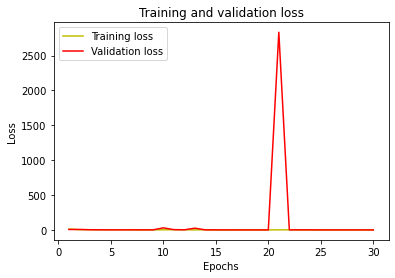

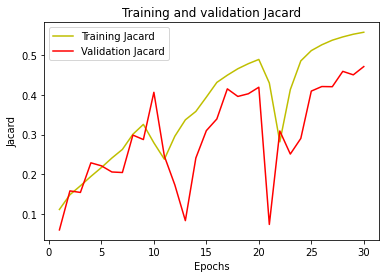

In [16]:

#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['jacard_coef']
#acc = history.history['accuracy']
val_acc = history.history['val_jacard_coef']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Jacard')
plt.plot(epochs, val_acc, 'r', label='Validation Jacard')
plt.title('Training and validation Jacard')
plt.xlabel('Epochs')
plt.ylabel('Jacard')
plt.legend()
plt.show()

#######################################################

In [21]:
model = unet_model
model = att_unet_model
model = att_res_unet_model

model_path_unet = "mitochondria_UNet_50epochs_B_focal.hdf5"
model_path_aunet = "mitochondria_Attention_UNet_50epochs_B_focal.hdf5"
model_path_aresunet = "mitochondria_AttResUnet_50epochs_B_focal.hdf5"
#Load one model at a time for testing.
model = tf.keras.models.load_model(model_path_unet, compile=False)



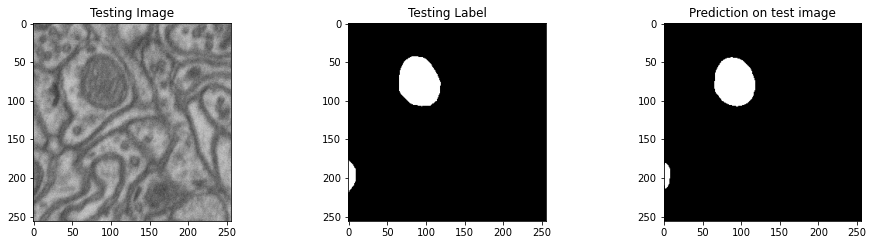

Mean IoU = 0.95501053
0.94488657
0.92854005
1.0
0.86078155
0.9417846
0.6854472
0.93134016
0.71481824
0.91738737
0.89715284
0.9155344
1.0
0.91784453
0.4999237
0.9376171
0.7419847
0.9075102
0.91549104
0.92540205
0.94585407
0.91202056
1.0
0.9205035
0.9536928
0.8454671
0.95872307
0.8397225
0.9478396
0.93388784
1.0
1.0
0.94324255
0.9550394
0.91576886
0.9210323
0.96227896
0.9342677
0.9146261
0.9622736
0.95501053
0.763386
0.91097116
0.8105848
0.9336391
0.86482453
0.9048333
0.9304454
0.908268
0.9232285
0.89743745
0.4985733
0.90783304
0.9103285
0.82868755
0.94015384
0.87554795
0.95115113
0.7867985
0.9085007
0.90629286
0.9561938
0.93625426
0.49975586
0.9507797
0.54579365
0.9242921
0.9558886
0.9274132
0.92165565
0.84597963
0.8287842
0.9210036
1.0
0.91120017
0.54883504
0.8237872
0.9418776
0.9225911
0.940037
0.94467473
0.89775586
0.9086945
0.8805758
0.95005846
0.49919128
0.49637604
0.91310805
0.94063586
0.9071566
0.9132206
0.87850636
0.91348577
0.49783325
0.89681435
0.72091776
0.9147812
1.0
0.94423

In [23]:


import random
test_img_number = random.randint(0, X_test.shape[0]-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()


#IoU for a single image
from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(ground_truth[:,:,0], prediction)
print("Mean IoU =", IOU_keras.result().numpy())


#Calculate IoU for all test images and average
 
import pandas as pd

IoU_values = []
for img in range(0, X_test.shape[0]):
    temp_img = X_test[img]
    ground_truth=y_test[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (model.predict(temp_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
    
    IoU = MeanIoU(num_classes=n_classes)
    IoU.update_state(ground_truth[:,:,0], prediction)
    IoU = IoU.result().numpy()
    IoU_values.append(IoU)

    print(IoU)
    


df = pd.DataFrame(IoU_values, columns=["IoU"])
df = df[df.IoU != 1.0]    
mean_IoU = df.mean().values
print("Mean IoU is: ", mean_IoU)

In [ ]:
aresunet IoU : 0.9
aunet IoU :0.867
unet IoU : 0.866